# Imports

In [1]:
!pip install emoji
!pip install nltk
!pip install tqdm
!pip install simplejson
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.4 MB/s eta 0:00:00


In [49]:
import sys
import shutil
import json
import urllib
import tarfile
from pathlib import Path
import simplejson as sj

import pandas as pd
import numpy as np

from typing import Dict, OrderedDict, List

import re
import emoji


import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from tqdm import tqdm


import gensim
import gensim.downloader as gloader



from typing import Iterable
from tqdm import tqdm


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Activation

# Task 1: Corpus

## 1. Downloading the dataset

First of all we need to **download** the `A1/data` folder.

In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)

In [4]:
def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

In [5]:
# Here we put all the urls
urls = {
    "training": "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%201/data/training.json",
    "test": "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%201/data/test.json",
    "validation": "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%201/data/validation.json"
}

In [6]:
print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

Current work directory: /content


In [7]:
if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

In [8]:
for name, url in urls.items():
    download_path = dataset_folder.joinpath(f"{name}.json")
    download_dataset(download_path, url)

training.json: 6.23MB [00:00, 13.7MB/s]                            


Download complete!


test.json: 500kB [00:00, 1.67MB/s]                            


Download complete!


validation.json: 1.16MB [00:00, 3.91MB/s]                            

Download complete!


## 2. Load the three JSON files and encode them as pandas dataframes.

In [9]:
def load_json_file(file_path: Path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

In [10]:
dataframe_rows = []


for name, url in urls.items():
    # per ogni file creiamo il file_path e leggiamo il file
    file_path = dataset_folder.joinpath(f"{name}.json")

    json_data = load_json_file(file_path)

    # per ogni chiave nel json_data creo una dataframe_row
    for key in json_data.keys():
        df_row = json_data[key]
        df_row["split"] = name
        dataframe_rows.append(df_row)


In [11]:
folder = Path.cwd().joinpath("Datasets", "Dataframes")
if not folder.exists():
    folder.mkdir(parents=True)


# transform the list of rows in a proper dataframe
df = pd.DataFrame(dataframe_rows)

for name, url in urls.items():
  df_path = folder.with_name(name + ".pkl")
  df.to_pickle(df_path)

## 3. Generate hard labels

Generate hard labels for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.

In [12]:
def compute_majority_voting(labels: list):

    unique_labels, counts = np.unique(labels, return_counts=True)
    majority_label = np.argwhere(counts == np.max(counts))

    majority_label = unique_labels[majority_label].flatten().tolist()

    if len(majority_label) > 1:
        majority_label = None


    return majority_label

In [13]:
def generate_hard_labels(df):
    hard_labels = []

    for index, row in df.iterrows():
        # Estrai le etichette dalla colonna 'labels_task1'
        labels = row['labels_task1']
        # print(labels)

        # Verifica se 'labels' è una lista e contiene elementi
        if isinstance(labels, list) and len(labels) > 0:
            # Calcola la moda (voto di maggioranza)
            most_common_label = compute_majority_voting(labels)
            # print(most_common_label)
            hard_labels.append(most_common_label)

    # Aggiungi le hard labels come nuova colonna
    df['hard_label_task1'] = hard_labels

    # Rimuovi le righe senza una chiara maggioranza (se necessario)
    df = df[df['hard_label_task1'].notnull()]

    return df

In [14]:
df = generate_hard_labels(df)
print(df.head())

  id_EXIST lang                                              tweet  \
0   100001   es  @TheChiflis Ignora al otro, es un capullo.El p...   
1   100002   es  @ultimonomada_ Si comicsgate se parece en algo...   
2   100003   es  @Steven2897 Lee sobre Gamergate, y como eso ha...   
4   100005   es  @novadragon21 @icep4ck @TvDannyZ Entonces como...   
5   100006   es  @yonkykong Aaah sí. Andrew Dobson. El que se d...   

   number_annotators                                         annotators  \
0                  6  [Annotator_1, Annotator_2, Annotator_3, Annota...   
1                  6  [Annotator_7, Annotator_8, Annotator_9, Annota...   
2                  6  [Annotator_7, Annotator_8, Annotator_9, Annota...   
4                  6  [Annotator_19, Annotator_20, Annotator_21, Ann...   
5                  6  [Annotator_25, Annotator_26, Annotator_27, Ann...   

    gender_annotators                          age_annotators  \
0  [F, F, F, M, M, M]  [18-22, 23-45, 46+, 46+, 23-45, 18-22]  

## 4. Filter the DataFrame

Filter the DataFrame to keep only rows where the `lang` column is `'en'`.

In [15]:
df = df[df['lang'] == 'en']
print(df.shape)

(3314, 12)


## 5. Remove unwanted columns

Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.

In [16]:
def remove_unwanted_columns(df):

    columns_to_keep = ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', 'split']
    df = df[columns_to_keep]
    return df

In [17]:
df = remove_unwanted_columns(df)

## 6. Encode the hard_label_task1 column

Use 1 to represent "YES" and 0 to represent "NO" in the `hard_label_task1 column`.

In [18]:
df['hard_label_task1'] = df['hard_label_task1'].apply(lambda x: 1 if x[0] == 'YES' else 0)
print(df.head())

     id_EXIST lang                                              tweet  \
3661   200002   en  Writing a uni essay in my local pub with a cof...   
3662   200003   en  @UniversalORL it is 2021 not 1921. I dont appr...   
3665   200006   en  According to a customer I have plenty of time ...   
3666   200007   en  So only 'blokes' drink beer? Sorry, but if you...   
3667   200008   en  New to the shelves this week - looking forward...   

      hard_label_task1     split  
3661                 1  training  
3662                 1  training  
3665                 1  training  
3666                 1  training  
3667                 0  training  


# Task 2: Data Cleaning

In [19]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Check this link: [all existing emojis](https://www.unicode.org/Public/emoji/1.0//emoji-data.txt). And also this: [emojis unicode consortium](https://unicode.org/emoji/charts/full-emoji-list.html).

In [20]:
def lower(text):
    return text.lower()

In [21]:
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

In [22]:
def remove_hastag(text):
    at = re.compile(r'#\S+')
    return at.sub(r'',text)

In [23]:
def remove_mention(text):
    at = re.compile(r'@\S+')
    return at.sub(r'',text)

In [24]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [25]:
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    return re.sub(pattern, '', text)

In [26]:
def remove_quotes(text):
    pattern = r'^"|"$‘’'
    return re.sub(pattern, '', text)

In [27]:
def remove_extra_spaces(text):
    text.strip()
    pattern = r'\s+'
    return re.sub(pattern, ' ', text)

In [28]:
def remove_word_repetitions(text):
    return  re.sub(r'\b(\w+)( \1\b)+', r'\1', text)


In [29]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()


    def get_wordnet_key(pos_tag):
        if pos_tag.startswith('J'):
            return wordnet.ADJ
        elif pos_tag.startswith('V'):
            return wordnet.VERB
        elif pos_tag.startswith('N'):
            return wordnet.NOUN
        elif pos_tag.startswith('R'):
            return wordnet.ADV
        else:
            return 'n'


    def lem_text(text: str):
        tokens = nltk.word_tokenize(text)
        tagged = pos_tag(tokens)
        words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tagged]
        return " ".join(words)


    return lem_text(text)

In [30]:
def clean_tweet(tweet: str):
    tweet = lower(tweet)
    tweet = remove_emoji(tweet)
    tweet = remove_hastag(tweet)
    tweet = remove_mention(tweet)
    tweet = remove_URL(tweet)
    tweet = remove_special_characters(tweet)
    tweet = remove_quotes(tweet)
    tweet = remove_word_repetitions(tweet)
    tweet = remove_extra_spaces(tweet)
    tweet = lemmatize(tweet)
    return tweet

In [31]:
df['tweet'] = df['tweet'].apply(clean_tweet)

In [32]:
print(df['tweet'].head())

3661    write a uni essay in my local pub with a coffe...
3662    it be 2021 not 1921 i dont appreciate that on ...
3665    accord to a customer i have plenty of time to ...
3666    so only blokes drink beer sorry but if you are...
3667    new to the shelf this week look forward to rea...
Name: tweet, dtype: object


# Task 3: Text Encoding

## Splitting the dataset

Here we split the dataset in train, test and validation.

In [33]:
df_train = df.loc[df['split'] == "training"].drop(columns=['split'])
df_test = df.loc[df['split'] == "test"].drop(columns=['split'])
df_val = df.loc[df['split'] == "validation"].drop(columns=['split'])

print(f"Train size: {df_train.shape}")
print(f"Test size: {df_test.shape}")
print(f"Validation size: {df_val.shape}")

Train size: (2870, 4)
Test size: (286, 4)
Validation size: (158, 4)


### Try to use Tokenizer to build the vocabulary

 ## Vocabulary Creation

We create the vocabulary only using the training dataset.

In [34]:
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 0
    # '''
    word_to_idx["[PAD]"] = curr_idx         #add the PAD index
    idx_to_word[curr_idx] = "[PAD]"
    curr_idx += 1
    # Here we add the special token [UNK] to our vocabulary
    word_to_idx["[UNK]"] = curr_idx
    idx_to_word[curr_idx] = "[UNK]"
    curr_idx += 1
    # '''
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1



    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [35]:
idx_to_word_train, word_to_idx_train, word_listing_train = build_vocabulary(df_train)

print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word_train)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx_train)}')
print(f'[Debug] Some words: {[(idx_to_word_train[idx], idx) for idx in np.arange(10) ]}')

100%|██████████| 2870/2870 [00:00<00:00, 126034.20it/s]

[Debug] Index -> Word vocabulary size: 9820
[Debug] Word -> Index vocabulary size: 9820
[Debug] Some words: [('[PAD]', 0), ('[UNK]', 1), ('write', 2), ('a', 3), ('uni', 4), ('essay', 5), ('in', 6), ('my', 7), ('local', 8), ('pub', 9)]


### Vocabulary Evaluation

In [36]:
def evaluate_vocabulary(idx_to_word: Dict[int, str], word_to_idx: Dict[str, int],
                        word_listing: List[str], df: pd.DataFrame, check_default_size: bool = False):
    print("[Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("[Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("[Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    print("[Vocabulary Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        'tweet': ["all that glitters is not gold", "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df)
    toy_valid_vocabulary = set(' '.join(toy_df.tweet.values).split())
    # Includi anche [UNK] nel confronto
    toy_valid_vocabulary.add("[UNK]")
    toy_valid_vocabulary.add("[PAD]")           #add pad to the test
    assert set(toy_word_listing) == toy_valid_vocabulary

In [37]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_train, word_to_idx_train, word_listing_train, df_train)
print("Evaluation completed!")

Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 9820/9820 [00:00<00:00, 1285119.04it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 2870/2870 [00:00<00:00, 186578.20it/s]


[Vocabulary Evaluation] Toy example checking...


100%|██████████| 2/2 [00:00<00:00, 15141.89it/s]

Evaluation completed!


## Saving Vocabulary

In [38]:
vocab_path = Path.cwd().joinpath('Datasets', 'vocab.json')

print(f"Saving vocabulary to {vocab_path}")
with vocab_path.open(mode='w') as f:
    sj.dump(word_to_idx_train, f, indent=4)
print("Saving completed!")

Saving vocabulary to /content/Datasets/vocab.json
Saving completed!


## GloVe embedding

In [39]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""

    if model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [40]:
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=50)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [41]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [42]:
oov_terms_train = check_OOV_terms(embedding_model, word_listing_train)
oov_percentage_train = float(len(oov_terms_train)) * 100 / len(word_listing_train)
print(f"Total OOV terms in training set: {len(oov_terms_train)} ({oov_percentage_train:.2f}%)")

Total OOV terms in training set: 1842 (18.76%)


Try to use Blob correct in order to correct spelling errors in tweets.

### Handling train dataset OOV terms

We have to put all the unseen tokens in the train dataset in our vocabulary.

In [43]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
          if word == '[PAD]':
            # we assign a random embedding to the [PAD] token
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
          elif word == '[UNK]':
            # we assign a random embedding to the [UNK] token
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
          else:
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [44]:
# Testing
embedding_dimension = 50
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx_train, len(word_to_idx_train), oov_terms_train)
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 9820/9820 [00:00<00:00, 283311.20it/s]


Embedding matrix shape: (9820, 50)


# Task 4: Model Definition

First of all we define the Base Model.

## Definition of the Base Model

In [127]:
def createModelBase(word_to_idx_train, embedding_dimension, embedding_matrix, units_dim = 64):

    embedding = tf.keras.layers.Embedding(input_dim=len(word_to_idx_train),
                                        output_dim=embedding_dimension,
                                        weights=[embedding_matrix],
                                        mask_zero=True,                   # automatically masks padding tokens
                                        name='encoder_embedding')
    model = Sequential()
    model.add(embedding)
    model.add(Bidirectional(LSTM(units = units_dim)))
    # model.add(TimeDistributed(Dense(units=1)))
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))

    model.compile(optimizer='adamw',
                  loss='binary_crossentropy',
                  metrics = [tf.keras.metrics.F1Score(
                                    average='macro', threshold=0.5, name='f1_score'
                                )])
    # model.summary()
    return model

## Definition of Model 1

In [128]:
def createModel1(word_to_idx_train,embedding_dimension,embedding_matrix,units_dim=64):

    embedding = tf.keras.layers.Embedding(input_dim=len(word_to_idx_train),
                                          output_dim=embedding_dimension,
                                          weights=[embedding_matrix],
                                          mask_zero=True,                   # automatically masks padding tokens
                                          name='encoder_embedding')
    model = Sequential()
    model.add(embedding)
    model.add(Bidirectional(LSTM(units=units_dim)))
    model.add(LSTM(units=units_dim))
    # model.add(TimeDistributed(Dense(units=1, activation='sigmoid')))  # Attivazione sigmoid per classificazione binaria
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adamw',
                  loss='binary_crossentropy',
                  metrics = [tf.keras.metrics.F1Score(
                                    average='macro', threshold=0.5, name='f1_score'
                                )])
    # model.summary()
    return model

# Task 5:  Training and Evaluation

We will use as reference the longest tweet in the dataset.

## Input Data Preparation

In [129]:
max_tweet_length=0
for t in df['tweet']:
    if len(t)>max_tweet_length:
        max_tweet_length=len(t)
print(max_tweet_length)

277


In [119]:
def prepare_input(data, vocabulary):
    X=[]
    for tokens in data['tweet']:
        indices = []
        for i in range(max_tweet_length):
            if i < len(tokens):
                if tokens[i] in vocabulary:
                    indices.append(vocabulary[tokens[i]])
                else:
                    # Handle out-of-vocabulary tokens if necessary
                    indices.append(vocabulary['[UNK]'])  # Example: -1 for unknown tokens
            else:
                indices.append(vocabulary['[PAD]'])
        X.append(indices)


    return np.array(X), np.array(data['hard_label_task1']).reshape(-1,1)

In [137]:
def prepare_input(data, vocabulary):
    X=[]
    for tokens in data['tweet']:
        indices = []
        for i in range(max_tweet_length):
            if i < len(tokens):
                if tokens[i] in vocabulary:
                    indices.append(vocabulary[tokens[i]])
                else:
                    # Handle out-of-vocabulary tokens if necessary
                    indices.append(vocabulary['[UNK]'])  # Example: -1 for unknown tokens
        X.append(indices)

    X = pad_sequences(X, maxlen = max_tweet_length, padding = 'post', value = 0)

    return X, np.array(data['hard_label_task1']).reshape(-1,1)

In [138]:
X_train, y_train = prepare_input(df_train, word_to_idx_train)
X_val, y_val = prepare_input(df_val, word_to_idx_train)
X_test, y_test = prepare_input(df_test, word_to_idx_train)

In [143]:
print(X_train.shape)  # Dovrebbe essere (num_samples, max_tweet_length, 1)
print(y_train.shape)  # Dovrebbe essere (num_samples, 1)

(2870, 277)
(2870, 1)


## Model Training and Evaluation

In [156]:
def select_best_model(results, model_names):

      valori_per_nome = {nome: [] for nome in model_names}

      for record in results:
          nome = record["model_name"]
          if nome in model_names:
              valori_per_nome[nome].append(record["macro_f1"])

      medie = {nome: sum(valori) / len(valori) for nome, valori in valori_per_nome.items() if valori}

      best_model_name = max(medie, key=medie.get)

      return best_model_name, medie[best_model_name]

In [157]:
import matplotlib.pyplot as plt

def plot_f1_score(history):
    """
    Plotta la matrice F1-score per il set di validazione.

    Parameters:
    - history: oggetto History di Keras contenente i valori di F1-score.
    """
    # Estrai i valori di F1-score dalla storia
    val_f1_scores = history.history.get('val_f1_score', [])
    f1_scores = history.history.get('f1_score', [])

    # Creazione del grafico
    plt.figure(figsize=(10, 6))

    # Plot F1-score per il set di addestramento
    plt.plot(f1_scores, label='F1 Score (Training)', color='blue')

    # Plot F1-score per il set di validazione
    plt.plot(val_f1_scores, label='F1 Score (Validation)', color='orange')

    plt.title('F1 Score for validation and train')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid()
    plt.show()

In [159]:
# Define a function to train a model
def train_model(model, X_train, y_train, X_val, y_val, epochs):
    history = model.fit(X_train,
                        y_train,
                        epochs = epochs,
                        batch_size = 64,
                        validation_data = (X_val, y_val)
                        )
    return model, history


# Main function to handle tasks
def train_and_evaluate(models, X_train, y_train, X_val, y_val, epochs=2, seeds=[42, 100, 2023]):
    results = []

    # Loop over seeds
    for seed in seeds:
        print(f"\n\n###### Evaluating models with seed {seed} ######")

        # setting the seed
        tf.random.set_seed(seed)


        # Train and evaluate each model
        for model_name in models:
            print(f"Training and evaluating model: {model_name}")

            if model_name == 'model_base':
                model = createModelBase(word_to_idx_train, embedding_dimension, embedding_matrix)
            if model_name == 'model_1':
                model = createModel1(word_to_idx_train, embedding_dimension, embedding_matrix)


            # Train the model
            trained_model, history = train_model(model, X_train, y_train, X_val, y_val, epochs)
            macro_f1 = history.history['val_f1_score'][-1]
            plot_f1_score(history=history)


            # Evaluate the model
            # loss, macro_f1 = trained_model.evaluate(X_val, y_val, verbose = 2)

            # Store results
            results.append({
                'seed': seed,
                'model_name': model_name,
                'macro_f1': macro_f1
            })

    best_model_name, mean_f1_score = select_best_model(results, models)
    # Aggregate results to find the best model
    # best_model = max(results, key = lambda x: x['macro_f1'])
    macro_f1_values = [result['macro_f1'] for result in results]
    average_macro_f1 = np.mean(macro_f1_values)

    print(f"\n\n\n ###### Best model: {best_model_name} with macro F1-score: {mean_f1_score:.4f} ######")

    return results, best_model_name



###### Evaluating models with seed 42 ######
Training and evaluating model: model_base
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - f1_score: 0.0903 - loss: 0.6742 - val_f1_score: 0.1463 - val_loss: 0.6856
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - f1_score: 0.0679 - loss: 0.6596 - val_f1_score: 0.2247 - val_loss: 0.6826
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - f1_score: 0.2213 - loss: 0.6534 - val_f1_score: 0.3529 - val_loss: 0.6800
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - f1_score: 0.2975 - loss: 0.6451 - val_f1_score: 0.4839 - val_loss: 0.6767
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - f1_score: 0.3818 - loss: 0.6336 - val_f1_score: 0.4571 - val_loss: 0.6660
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - f1_score: 0.4138 - loss: 0.6248 - val_f1_score: 0.4259 - val_loss: 0.6743
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.4523 - loss: 0.6149 - val_f1_score: 0.5535 - val_loss: 0.7001
Epoch 8/20
45/45 ━━━━━

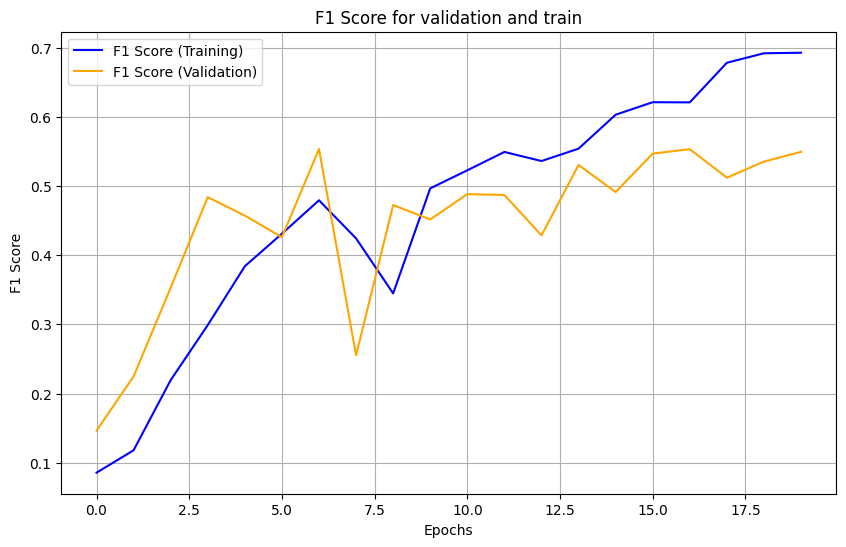



###### Evaluating models with seed 50 ######
Training and evaluating model: model_base
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - f1_score: 0.1226 - loss: 0.6823 - val_f1_score: 0.0000e+00 - val_loss: 0.6896
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - f1_score: 0.0782 - loss: 0.6696 - val_f1_score: 0.0000e+00 - val_loss: 0.6988
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.1905 - loss: 0.6658 - val_f1_score: 0.0000e+00 - val_loss: 0.6977
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.2147 - loss: 0.6619 - val_f1_score: 0.0000e+00 - val_loss: 0.7075
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.3362 - loss: 0.6526 - val_f1_score: 0.2308 - val_loss: 0.6736
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - f1_score: 0.4025 - loss: 0.6383 - val_f1_score: 0.1096 - val_loss: 0.6859
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - f1_score: 0.3810 - loss: 0.6338 - val_f1_score: 0.2927 - val_loss: 0.6747
Epoch 

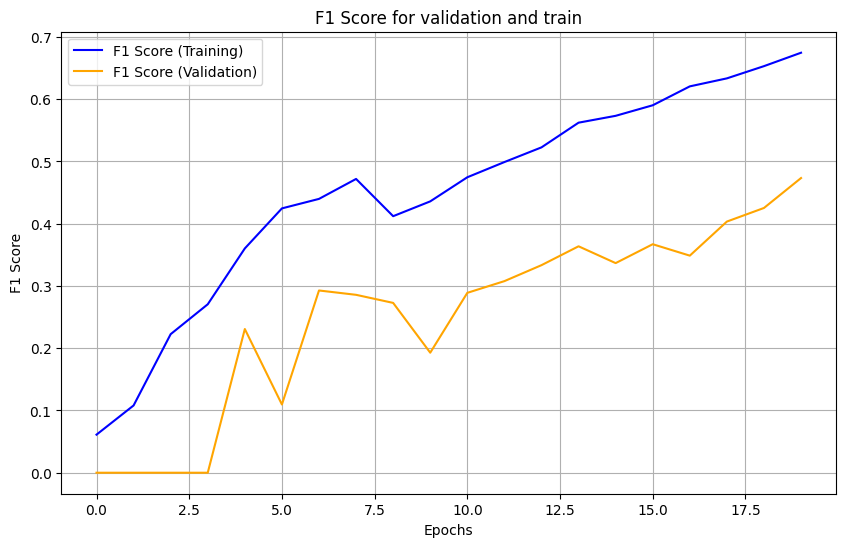



###### Evaluating models with seed 84 ######
Training and evaluating model: model_base
Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - f1_score: 0.1311 - loss: 0.6837 - val_f1_score: 0.0000e+00 - val_loss: 0.6839
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.0654 - loss: 0.6685 - val_f1_score: 0.0286 - val_loss: 0.6818
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.1433 - loss: 0.6652 - val_f1_score: 0.1096 - val_loss: 0.6794
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.2035 - loss: 0.6607 - val_f1_score: 0.1282 - val_loss: 0.6779
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.2484 - loss: 0.6553 - val_f1_score: 0.1316 - val_loss: 0.6780
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.3172 - loss: 0.6496 - val_f1_score: 0.1538 - val_loss: 0.6797
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1_score: 0.3312 - loss: 0.6430 - val_f1_score: 0.2619 - val_loss: 0.6773
Epoch 8/20
45/45 ━

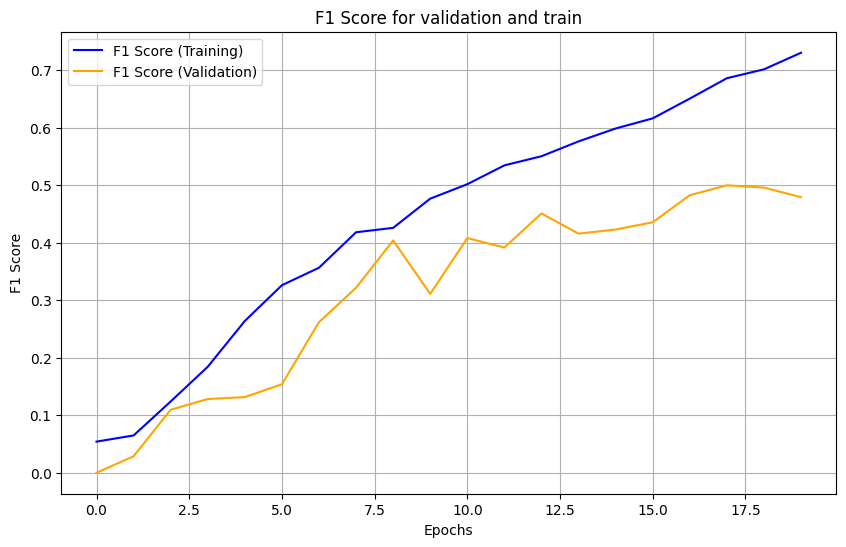




 ###### Best model: model_base with macro F1-score: 0.5006 ######


In [160]:
'''
models = ['model_base',
          'model_1']
'''
models = ['model_base']
seeds=[42, 50, 84]
# seeds=[50]


# Train and evaluate models
results, best_model = train_and_evaluate(models,
                                         X_train,
                                         y_train,
                                         X_val,
                                         y_val,
                                         epochs = 20,
                                         seeds = seeds)

In [161]:
# Print detailed results
for result in results:
    print(f"Seed: {result['seed']}, Model: {result['model_name']}, Macro F1: {result['macro_f1']:.4f}")

Seed: 42, Model: model_base, Macro F1: 0.5493
Seed: 50, Model: model_base, Macro F1: 0.4733
Seed: 84, Model: model_base, Macro F1: 0.4793
